In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

In [2]:
SIZE_FULL = 768 # original dataset's images size
SIZE = 256 #size used for using in model (3x3 squares to make original image)

In [3]:
def crop3x3(img, i):
    """img: np.ndarray - original image 768x768
       i: int 0-8 - image index from crop: 0 1 2
                                           3 4 5
                                           6 7 8
       returns: image 256x256 
    """
    return img[(i//3)*SIZE: ((i//3)+1)*SIZE,(i%3)*SIZE: (i%3+1)*SIZE]


def crop3x3_mask(img):
    """Returns crop image, crop index with maximum ships area"""
    i = K.argmax((
        K.sum(crop3x3(img, 0)),
        K.sum(crop3x3(img, 1)),
        K.sum(crop3x3(img, 2)),
        K.sum(crop3x3(img, 3)),
        K.sum(crop3x3(img, 4)),
        K.sum(crop3x3(img, 5)),
        K.sum(crop3x3(img, 6)),
        K.sum(crop3x3(img, 7)),
        K.sum(crop3x3(img, 8)),
    ))
    return (crop3x3(img, i), i)

In [4]:
# https://www.kaggle.com/code/stainsby/fast-tested-rle/notebook
def decode(mask_rle):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img=np.zeros(SIZE_FULL*SIZE_FULL, dtype=np.float32)
    for mask in mask_rle:
        s = mask.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for (lo, hi) in zip(starts, ends):
            img[lo:hi] = 1.0
    return img.reshape((SIZE_FULL, SIZE_FULL)).T

In [5]:
def get_rle_dict(data):
    rle_dict: dict = {}
    for _, (image_id, rle_str) in data.iterrows():
        if isinstance(rle_str, float):
            rle_dict[image_id] = []
        elif image_id in rle_dict:
            rle_dict[image_id].append(rle_str)
        else:
            rle_dict[image_id] = [rle_str]
    return rle_dict

In [6]:
class TrainDataGenerator(tfk.utils.Sequence):

    def __init__(self, datapath ,batch_size, df_mask: pd.DataFrame):
        self.datapath = datapath
        self.batch_size = batch_size
        self.df =  df_mask.sample(frac=1)
        self.l = len(self.df)//batch_size

    def __len__(self):
        return self.l

    def on_epoch_end(self):
        pass
#         self.df.sample(frac=1, replace=True)

    def __getitem__(self, index):
        mask = np.empty((self.batch_size, SIZE , SIZE), np.float32)
        image = np.empty((self.batch_size, SIZE, SIZE, 3), np.float32)
        
        for b in range(self.batch_size):
            temp = tfk.preprocessing.image.load_img(self.datapath + '/' + self.df.iloc[index*self.batch_size+b]['ImageId'])
            temp = tfk.preprocessing.image.img_to_array(temp)/255
        
            mask[b], i = crop3x3_mask( # decoding mask from run-length format, and cropping part with maximum ship's area(№ i)
                decode(
                    self.df.iloc[index*self.batch_size+b]['EncodedPixels']
                )
            ) 
            image[b] = crop3x3(temp, i) # using corresponding to mask crop of image (№ i)
            
        return image, mask
    
    def getitem(self, index):
        return self.__getitem__(index)
    

def get_datagenerator(datapath ,batch_size, df_mask):
    d = TrainDataGenerator(datapath, df_mask=df_mask, batch_size=1)
    def _():
        for i in range(len(d)):
            x, y =  d.getitem(i)
            yield x[0], y[0]
    return tf.data.Dataset.from_generator(
        _, output_signature=(
            tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(SIZE, SIZE), dtype=tf.float32),
        ), 
    )

## UNET

In [10]:
# dropout = 0.2
dropout = 0.2

k =2
def dconv(prev, filters, kernel_size=3):
    prev = tfl.BatchNormalization()(prev)
    prev = tfl.Conv2D(filters, kernel_size, padding="same", activation="elu", kernel_initializer= 'he_normal')(prev)
    prev = tfl.Dropout(dropout)(prev)
    prev = tfl.Conv2D(filters, kernel_size, padding="same", activation="elu", kernel_initializer= 'he_normal')(prev)
    return prev
    


def down(prev, filters, kernel_size=3): 
    skip = dconv(prev, filters, kernel_size)
    prev = tfl.MaxPool2D(strides=2, padding='valid')(skip)
    return prev, skip


def bridge(prev, filters,kernel_size=3):  
    prev = dconv(prev, filters, kernel_size)
    prev = tfl.Conv2DTranspose(filters // 2, 2, strides=(2, 2))(prev)
    return prev


def up(prev, skip, filters, kernel_size=3):  
    prev = tfl.concatenate([prev, skip], axis=3) 
    prev = tfl.Dropout(dropout)(prev)
    prev = dconv(prev, filters, kernel_size)
    prev = tfl.Conv2DTranspose(filters // 2, 2, strides=(2, 2))(prev)
    return prev


def last(prev, skip, filters,kernels_size=(3,3)):
    prev = tfl.concatenate([prev, skip], axis=3)
    prev = tfl.Dropout(dropout)(prev)
    prev = tfl.Conv2D(filters, kernels_size[0], padding="same",activation="elu", kernel_initializer= 'he_normal')(prev)
    prev = tfl.Conv2D(filters, kernels_size[1], padding="same",activation="elu", kernel_initializer= 'he_normal')(prev)
    prev = tfl.Conv2D(filters=1, kernel_size=1,padding="same", activation="sigmoid")(prev)
    return prev


def unet_model(input_shape):
    inp = tfk.Input(shape=input_shape)
    inp = tfl.BatchNormalization()(inp)
    out, skip_1 = down(inp, k*16)
    out, skip_2 = down(out, k*32)
    out, skip_3 = down(out, k*64)
    out, skip_4 = down(out, k*128)
    out = bridge(out, k*256)
    out = up(out, skip_4, k*128)
    out = up(out, skip_3, k*64)
    out = up(out, skip_2, k*32)
    out = last(out, skip_1, k*16)

    model = tfk.Model(inputs=inp, outputs=out)
    return model

### Losses

In [11]:
import keras.backend as K

def dice_score(y_true, y_pred):
    return (2.0*K.sum(y_pred * y_true)+0.0001) / (K.sum(y_true)+ K.sum(y_pred)+0.0001)

def BFCE_dice(y_true, y_pred):
    return  K.binary_focal_crossentropy(y_true, y_pred)+  (1-dice_score(y_true, y_pred))*0.1

def BCE_dice(y_true, y_pred):
    return  K.binary_crossentropy(y_true, y_pred)+  (1-dice_score(y_true, y_pred))

### Train

In [19]:
empty, has_ships = 1000, 9000
df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")

In [20]:
df = pd.DataFrame(get_rle_dict(df).items(), columns=['ImageId', "EncodedPixels"])

In [21]:
df = pd.concat([df[df["EncodedPixels"].isin([[]])].sample(empty), df[~df["EncodedPixels"].isin([[]])].sample(has_ships)])

In [12]:
batch_size = 32
train_df, valid_df = train_test_split(df, test_size=0.2)
train = get_datagenerator("/kaggle/input/airbus-ship-detection/train_v2", 1, train_df)
valid = get_datagenerator("/kaggle/input/airbus-ship-detection/train_v2", 1, valid_df)
model = unet_model((SIZE, SIZE, 3))

In [13]:
train = train.cache().batch(batch_size).prefetch(1)
valid = valid.cache().batch(batch_size).prefetch(1)

In [14]:
callback = tfk.callbacks.ModelCheckpoint("./models/model.{epoch:02d}-{val_loss:.4f}-dice:{val_dice_score:.4f}.h5", "val_loss", save_best_only=True, save_weights_only=True)

In [15]:
model.compile(tf.keras.optimizers.Adam(0.001) , BCE_dice  , dice_score)
history = model.fit(train, validation_data=valid, batch_size = batch_size,epochs=8, verbose=1, callbacks=[callback], shuffle=True)

Epoch 1/8


2024-07-15 17:36:50.197542: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 444s 2s/step - loss: 0.6150 - dice_score: 0.5072 - val_loss: 0.5970 - val_dice_score: 0.5187
Epoch 2/8
250/250 [==============================] - 110s 441ms/step - loss: 0.4489 - dice_score: 0.6388 - val_loss: 0.4317 - val_dice_score: 0.6527
Epoch 3/8
250/250 [==============================] - 110s 441ms/step - loss: 0.4039 - dice_score: 0.6741 - val_loss: 0.3674 - val_dice_score: 0.6994
Epoch 4/8
250/250 [==============================] - 110s 441ms/step - loss: 0.3688 - dice_score: 0.7025 - val_loss: 0.3588 - val_dice_score: 0.7136
Epoch 5/8
250/250 [==============================] - 110s 441ms/step - loss: 0.3406 - dice_score: 0.7248 - val_loss: 0.3204 - val_dice_score: 0.7399
Epoch 6/8
250/250 [==============================] - 110s 441ms/step - loss: 0.3153 - dice_score: 0.7455 - val_loss: 0.3127 - val_dice_score: 0.7483
Epoch 7/8
250/250 [==============================] - 110s 441ms/step - loss: 0.2939 - dice_score: 0.7619 - val_loss: 0.

In [16]:
model.compile(tf.keras.optimizers.Adam(0.0005) , BCE_dice  , dice_score)
history2 = model.fit(train, validation_data=valid, batch_size = batch_size,epochs=8,verbose=1, callbacks=[callback], shuffle=True)

Epoch 1/8


2024-07-15 17:57:37.870456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 122s 444ms/step - loss: 0.2427 - dice_score: 0.8036 - val_loss: 0.2608 - val_dice_score: 0.7922
Epoch 2/8
250/250 [==============================] - 110s 442ms/step - loss: 0.2240 - dice_score: 0.8187 - val_loss: 0.2591 - val_dice_score: 0.7936
Epoch 3/8
250/250 [==============================] - 110s 442ms/step - loss: 0.2104 - dice_score: 0.8298 - val_loss: 0.2435 - val_dice_score: 0.8058
Epoch 4/8
250/250 [==============================] - 110s 442ms/step - loss: 0.2046 - dice_score: 0.8347 - val_loss: 0.2297 - val_dice_score: 0.8168
Epoch 5/8
250/250 [==============================] - 114s 458ms/step - loss: 0.1937 - dice_score: 0.8433 - val_loss: 0.2218 - val_dice_score: 0.8225
Epoch 6/8
250/250 [==============================] - 110s 442ms/step - loss: 0.1837 - dice_score: 0.8514 - val_loss: 0.2141 - val_dice_score: 0.8284
Epoch 7/8
250/250 [==============================] - 110s 441ms/step - loss: 0.1775 - dice_score: 0.8565 - val_loss:

In [23]:
model.compile(tf.keras.optimizers.Adam(0.0001) , BCE_dice  , dice_score)
history3 = model.fit(train, validation_data=valid, batch_size = batch_size,epochs=8,verbose=1, callbacks=[callback], shuffle=True)

Epoch 1/8


2024-07-15 18:13:52.028490: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 121s 442ms/step - loss: 0.1520 - dice_score: 0.8768 - val_loss: 0.1950 - val_dice_score: 0.8440
Epoch 2/8
250/250 [==============================] - 110s 440ms/step - loss: 0.1472 - dice_score: 0.8806 - val_loss: 0.1945 - val_dice_score: 0.8443
Epoch 3/8
250/250 [==============================] - 110s 439ms/step - loss: 0.1423 - dice_score: 0.8847 - val_loss: 0.1890 - val_dice_score: 0.8489
Epoch 4/8
250/250 [==============================] - 110s 439ms/step - loss: 0.1393 - dice_score: 0.8872 - val_loss: 0.1846 - val_dice_score: 0.8527
Epoch 5/8
250/250 [==============================] - 110s 439ms/step - loss: 0.1362 - dice_score: 0.8897 - val_loss: 0.1861 - val_dice_score: 0.8519
Epoch 6/8
250/250 [==============================] - 110s 439ms/step - loss: 0.1333 - dice_score: 0.8920 - val_loss: 0.1821 - val_dice_score: 0.8551
Epoch 7/8
250/250 [==============================] - 110s 439ms/step - loss: 0.1314 - dice_score: 0.8936 - val_loss:

In [26]:
model.compile(tf.keras.optimizers.Adam(0.00001) , BCE_dice  , dice_score)
history4 = model.fit(train, validation_data=valid, batch_size = batch_size,epochs=8,verbose=1, callbacks=[callback], shuffle=True)

Epoch 1/8


2024-07-15 18:32:20.977083: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 121s 441ms/step - loss: 0.1253 - dice_score: 0.8986 - val_loss: 0.1751 - val_dice_score: 0.8610
Epoch 2/8
250/250 [==============================] - 110s 439ms/step - loss: 0.1242 - dice_score: 0.8993 - val_loss: 0.1742 - val_dice_score: 0.8616
Epoch 3/8
250/250 [==============================] - 110s 439ms/step - loss: 0.1238 - dice_score: 0.8997 - val_loss: 0.1750 - val_dice_score: 0.8611
Epoch 4/8
250/250 [==============================] - 110s 440ms/step - loss: 0.1234 - dice_score: 0.9000 - val_loss: 0.1738 - val_dice_score: 0.8620
Epoch 5/8
250/250 [==============================] - 110s 440ms/step - loss: 0.1231 - dice_score: 0.9002 - val_loss: 0.1743 - val_dice_score: 0.8617
Epoch 6/8
250/250 [==============================] - 110s 440ms/step - loss: 0.1225 - dice_score: 0.9007 - val_loss: 0.1741 - val_dice_score: 0.8619
Epoch 7/8
250/250 [==============================] - 110s 440ms/step - loss: 0.1225 - dice_score: 0.9007 - val_loss:

In [30]:
model.save("final_model_val_dice_score=0.8627.keras", )

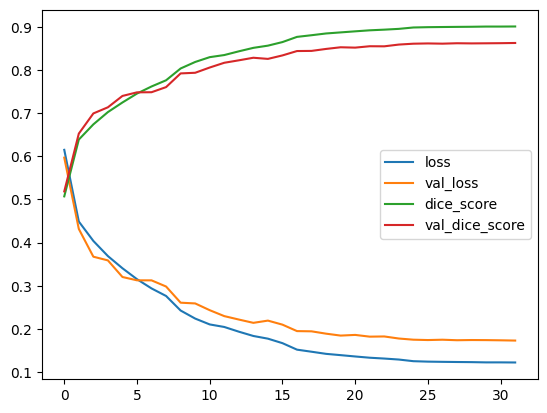

In [34]:
L = []
L.extend(history.history['loss'])
L.extend(history2.history['loss'])
L.extend(history3.history['loss'])
L.extend(history4.history['loss'])

LV=[]
LV.extend(history.history['val_loss'])
LV.extend(history2.history['val_loss'])
LV.extend(history3.history['val_loss'])
LV.extend(history4.history['val_loss'])


S = []
S.extend(history.history['dice_score'])
S.extend(history2.history['dice_score'])
S.extend(history3.history['dice_score'])
S.extend(history4.history['dice_score'])


V = []
V.extend(history.history['val_dice_score'])
V.extend(history2.history['val_dice_score'])
V.extend(history3.history['val_dice_score'])
V.extend(history4.history['val_dice_score'])


plt.plot(L, label="loss")
plt.plot(LV, label="val_loss")
plt.plot(S, label="dice_score")
plt.plot(V, label="val_dice_score")
plt.legend()